In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sn


import IPython.display as ipd
from IPython.display import Audio

import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
RAV = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"


In [3]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

male_calm          96
male_sad           96
male_fear          96
male_happy         96
male_disgust       96
male_angry         96
male_surprise      96
female_surprise    96
female_disgust     96
female_fear        96
female_sad         96
female_calm        96
female_happy       96
female_angry       96
male_neutral       48
female_neutral     48
Name: labels, dtype: int64

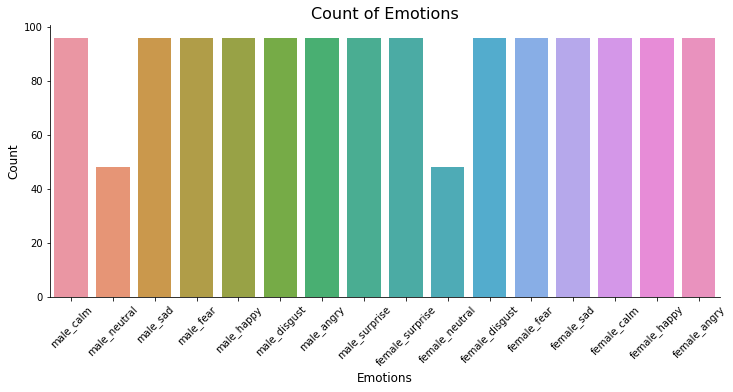

In [4]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAV_df.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [5]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [6]:
def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [7]:
RAV_df.head()


,labels,source,path
0,male_calm,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
1,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
2,male_sad,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
3,male_calm,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
4,male_calm,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...


In [8]:
path = np.array(RAV_df['path'])[0]
data, sample_rate = librosa.load(path)

In [9]:
X, Y = [], []
FLAG = 0
for path, emotion in zip(RAV_df['path'], RAV_df['labels']):
    feature = get_feat(path)
    for element in feature:
        X.append(element)
        Y.append(emotion)
   
        

In [10]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-626.262817,93.897247,-0.691273,17.833761,9.502006,2.030928,-2.721136,-8.514406,-12.427499,-6.575863,...,-2.750585,0.777975,-5.365466,-0.337154,1.482861,-8.703282,-2.764846,-1.618086,-1.523441,male_calm
1,-567.831101,74.691608,2.982113,14.153833,8.135078,1.189493,-3.838182,-9.273927,-11.415588,-6.328705,...,-2.433986,0.154037,-4.699649,-0.441504,1.479412,-7.853117,-4.223108,-0.867547,-2.896458,male_calm
2,-683.959106,90.017647,-4.683508,17.088537,6.352373,0.125587,-6.658744,-12.177227,-15.775248,-5.823675,...,-2.188844,-1.985480,-7.312302,-0.379691,-2.598665,-9.273556,-2.698469,-1.999992,-5.755872,male_calm
3,-634.959839,72.811478,-3.487027,20.697269,10.188320,-0.667841,-3.293634,-7.447817,-16.703850,-2.161060,...,-3.714514,0.273591,-4.517451,-1.117245,0.534381,-6.885533,-1.295200,-3.289555,0.756878,male_neutral
4,-438.492326,28.134047,8.580193,10.322097,5.186673,-0.666118,-2.754278,-6.714782,-8.605787,-4.746079,...,-2.143015,-1.594120,-1.766491,-0.324387,-0.514220,-3.986067,-2.439568,-0.820109,-2.124241,male_neutral


In [11]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [12]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [13]:
Y.shape

(4320, 16)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 16), (1080, 20), (1080, 16))

In [15]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 16), (1080, 20), (1080, 16))

In [16]:
neighbours = []
trainAcc = []
testAcc = []
for i in range(2,10):
    from sklearn.neighbors import KNeighborsClassifier
    clf1=KNeighborsClassifier(n_neighbors=i)
    clf1.fit(x_train,y_train)
    y_pred=clf1.predict(x_test)
    print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
    print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))
    print('---------------------------------------------------------')
    neighbours.append(i)
    trainAcc.append(clf1.score(x_train, y_train))
    testAcc.append(clf1.score(x_test, y_test))

Training set score: 0.769
Test set score: 0.548
---------------------------------------------------------
Training set score: 0.852
Test set score: 0.645
---------------------------------------------------------
Training set score: 0.618
Test set score: 0.457
---------------------------------------------------------
Training set score: 0.698
Test set score: 0.537
---------------------------------------------------------
Training set score: 0.518
Test set score: 0.395
---------------------------------------------------------
Training set score: 0.570
Test set score: 0.452
---------------------------------------------------------
Training set score: 0.432
Test set score: 0.329
---------------------------------------------------------
Training set score: 0.483
Test set score: 0.378
---------------------------------------------------------


Text(0, 0.5, 'Accuracy')

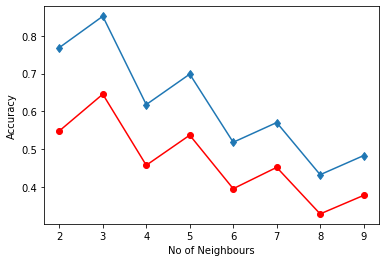

In [17]:
plt.plot(neighbours,trainAcc,marker = 'd')
plt.plot(neighbours,testAcc, 'red',marker = 'o')
plt.xlabel('No of Neighbours')
plt.ylabel('Accuracy')

In [18]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=3)
clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [19]:
pred_test = clf1.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [20]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,female_angry,female_sad
1,male_surprise,male_happy
2,female_angry,female_surprise
3,female_angry,female_angry
4,female_surprise,female_fear
5,female_surprise,female_sad
6,female_angry,male_disgust
7,male_sad,male_sad
8,female_surprise,female_surprise
9,male_neutral,male_calm


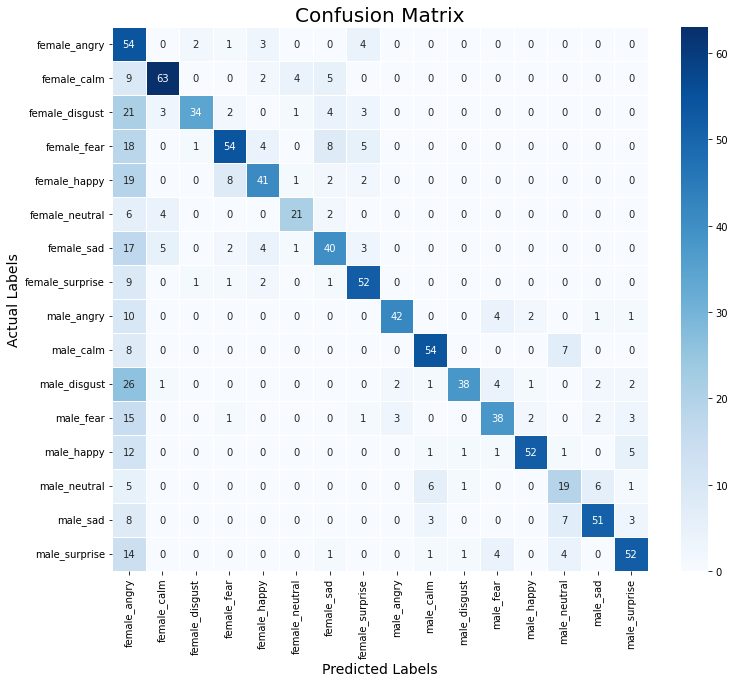

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [22]:
print(classification_report(y_test, y_pred))


                 precision    recall  f1-score   support

   female_angry       0.22      0.84      0.34        64
    female_calm       0.83      0.76      0.79        83
 female_disgust       0.89      0.50      0.64        68
    female_fear       0.78      0.60      0.68        90
   female_happy       0.73      0.56      0.64        73
 female_neutral       0.75      0.64      0.69        33
     female_sad       0.63      0.56      0.59        72
female_surprise       0.74      0.79      0.76        66
     male_angry       0.89      0.70      0.79        60
      male_calm       0.82      0.78      0.80        69
   male_disgust       0.93      0.49      0.64        77
      male_fear       0.75      0.58      0.66        65
     male_happy       0.91      0.71      0.80        73
   male_neutral       0.50      0.50      0.50        38
       male_sad       0.82      0.71      0.76        72
  male_surprise       0.78      0.68      0.72        77

       accuracy              